<a href="https://colab.research.google.com/github/Mariamtemi/Health-facilities-in-Nigeria/blob/master/mariamatoyebi_gmal_com_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Challenge

This is a basic notebook to train a  random forest classifier using the scikit learn random forest library to predict whether clients will default loan repayment . 

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('drive/My Drive/paylater')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


#Import the required modules

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [0]:
data = pd.read_csv('final_challenge.csv', header=0)
print(data.shape)


(159596, 35)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,12,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#data.info()
data.isnull().values.any()


False

**Fixing some columns**

1)  conversion of the date columns to the correct format.

2) obtaining the absolute values for the settleDays column

3) converting the string values of clienttimeatEmployer to numeric values


In [0]:
data['applicationDate'] =  pd.to_datetime(data['applicationDate'],errors="coerce"  )
data['approvalDate'] =  pd.to_datetime(data['approvalDate'],errors="coerce" )
data['disbursementDate'] =  pd.to_datetime(data['disbursementDate'],errors="coerce" )
data['dueDate'] =  pd.to_datetime(data['dueDate'], errors="coerce" )
data['paidAt'] =  pd.to_datetime(data['paidAt'],errors="coerce" )
data['repaidDate'] =  pd.to_datetime(data['repaidDate'],errors="coerce" )
data['repaymnentDueDate'] =  pd.to_datetime(data['repaymentDueDate'], errors="coerce" )
data['settleDays'] = data['settleDays'].abs()
data['clientTimeAtEmployer'] = pd.to_numeric(data['clientTimeAtEmployer'], errors='coerce')

#Data Exploration

Let's drop some columns, loan type and declined date and preview our data


In [0]:
data = data.drop(['loanType','declinedDate'], axis=1)   #drop two columns
data.head()

,clientId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,clientTimeAtEmployer,...,max_tenor_taken,id,repaidDate,repaymentDueDate,settleDays,firstPaymentRatio,firstPaymentDefault,ids,loanDefault,repaymnentDueDate
0,395301182,35000.00,false,28,FEMALE,Single,house,Own Residence,OYO,NaN,...,1,301714529828,2018-06-07 12:12:32,2018-06-08 12:00:00 UTC,1,0.0,0,301714529828,0,2018-06-08 12:00:00
1,492597075,70833.33,true,41,FEMALE,Married,education,Own Residence,KWARA,NaN,...,1,301714537708,2018-06-07 09:27:56,2018-06-08 12:00:00 UTC,1,0.0,0,301714537708,0,2018-06-08 12:00:00
2,769980240,25000.00,false,38,FEMALE,Married,house,Rented,LAGOS,NaN,...,1,301714552748,2018-06-08 12:49:13,2018-06-08 12:00:00 UTC,0,0.0,0,301714552748,0,2018-06-08 12:00:00
3,525296437,35000.00,false,32,FEMALE,Married,business,Rented,LAGOS,NaN,...,1,301714561362,2018-06-04 05:39:55,2018-06-08 12:00:00 UTC,4,0.0,0,301714561362,0,2018-06-08 12:00:00
4,800220186,97865.00,true,36,FEMALE,Single,business,Family Owned,ABUJA,27.0,...,1,301714565557,2018-06-08 07:28:10,2018-06-08 12:00:00 UTC,0,0.0,0,301714565557,0,2018-06-08 12:00:00


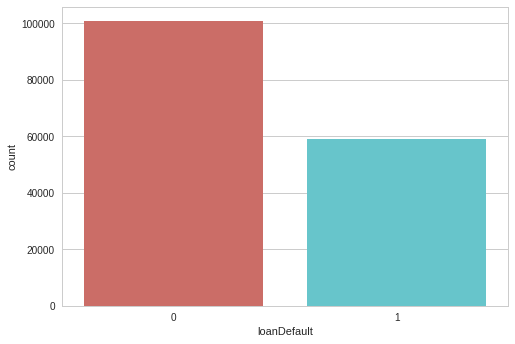

0    100740
1     58856
Name: loanDefault, dtype: int64

In [0]:
sns.countplot(x='loanDefault',data=data, palette='hls')
plt.show()
data['loanDefault'].value_counts()

In [0]:
count_no_defaulters = len(data[data['loanDefault']==0])
count_defaulters = len(data[data['loanDefault']==1])
pct_of_no_defaulters = count_no_defaulters/(count_no_defaulters+count_defaulters)
print("percentage of non loan_defaults is", pct_of_no_defaulters*100)
pct_of_defaulters = count_defaulters/(count_no_defaulters+count_defaulters)
print("percentage of loan_defaulters", pct_of_defaulters*100)

percentage of non loan_defaults is 63.12188275395373
percentage of loan_defaulters 36.878117246046266


we can see from the above analysis that our classes are imbalanced.  The ratio of non defaulters to defaulters in 63:37. Hence, we need to balance the data for our algorithm to perform better.

In [0]:
data.groupby('loanDefault').mean()

,clientId,clientIncome,clientAge,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,settleDays,firstPaymentRatio,firstPaymentDefault
loanDefault,,,,,,,,,,,,
0,4.980211e+08,92055.538940,33.833155,3.629482,34541.726226,13.364509,83.290351,0.681110,0.901022,2.557227,0.000000,0.161277
1,4.979862e+08,88756.880374,33.449980,3.432411,36663.466766,13.274282,88.971898,0.746636,0.939938,84.028035,0.265717,0.521901


The average age of both classes are almost the same.

The average income of non defaulters is slighter higher than for defaulters.
The average loan of defaulters is a little higher than for non defaulters.
Expectedly, the average settle days, firstpayment ratio and firstpaymentdefaults of defaulters are higher than for non-defaulters.


In [0]:
data.groupby('clientGender').mean()

,clientId,clientIncome,clientAge,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
clientGender,,,,,,,,,,,,,
FEMALE,4.975876e+08,79476.963147,32.809433,3.522451,34522.601642,13.133319,85.067094,0.707531,0.918947,29.407951,0.088898,0.278189,0.359844
MALE,4.981997e+08,96012.120203,34.093602,3.572447,35689.137928,13.421344,85.530611,0.704247,0.913747,34.056408,0.102131,0.301588,0.372850


In [0]:
data.groupby('clientMaritalStatus').mean()

,clientId,clientIncome,clientAge,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
clientMaritalStatus,,,,,,,,,,,,,
Divorced,3.661157e+08,105000.000000,45.000000,3.000000,27333.333333,15.833333,70.000000,1.000000,1.000000,7.000000,0.000000,0.333333,0.333333
Married,4.972362e+08,104808.194552,37.250772,3.409243,38431.636878,12.746401,87.531348,0.725378,0.916004,30.656482,0.096114,0.280634,0.366362
Null,2.677951e+08,53739.845000,30.333333,2.166667,26166.666667,15.000000,65.000000,0.500000,1.000000,2.000000,0.000000,0.333333,0.333333
Separated,5.228936e+08,99205.775671,39.289694,3.597772,38833.983287,12.808053,87.576602,0.738162,0.920334,28.476323,0.083464,0.270195,0.344847
Single,4.983401e+08,73834.545901,29.182060,3.734827,31461.617690,14.051537,82.754025,0.680063,0.914673,35.114306,0.100821,0.311445,0.372430
Widowed,4.973961e+08,95494.077764,41.680511,3.395101,39321.086262,12.818646,86.006390,0.728435,0.900958,26.991480,0.082586,0.275825,0.357827


In [0]:
data.groupby('clientLoanPurpose').mean()

,clientId,clientIncome,clientAge,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
clientLoanPurpose,,,,,,,,,,,,,
business,4.988771e+08,94393.284947,33.554827,3.403794,35908.142980,13.422613,86.357121,0.773210,0.939931,39.917950,0.121397,0.326859,0.397045
education,4.952692e+08,81046.734165,35.067357,3.488149,35956.503781,13.085713,85.672619,0.672047,0.910593,26.318485,0.072444,0.265235,0.342886
house,4.943528e+08,88297.531062,34.267896,3.763804,36109.015288,12.966078,86.142086,0.624236,0.883363,23.179406,0.067785,0.250000,0.338579
medical,4.957074e+08,85407.557332,32.488863,3.472089,31531.247182,13.828390,81.767517,0.667238,0.911804,32.219587,0.096194,0.310488,0.372982
other,5.005846e+08,90527.093949,33.365532,3.857894,34327.026684,13.307633,83.549154,0.622298,0.880110,24.201116,0.074072,0.252678,0.330766


#More EDA : Visualizations

Text(0, 0.5, 'Counts of clients')

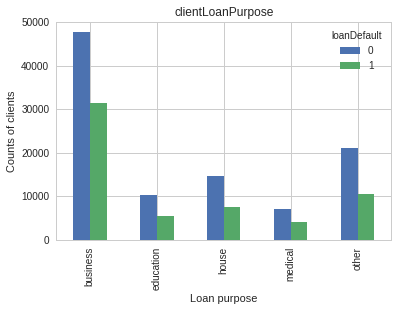

In [0]:
%matplotlib inline
pd.crosstab(data.clientLoanPurpose,data.loanDefault).plot(kind='bar')
plt.title('clientLoanPurpose')
plt.xlabel('Loan purpose')
plt.ylabel('Counts of clients')

Text(0, 0.5, 'Counts of clients')

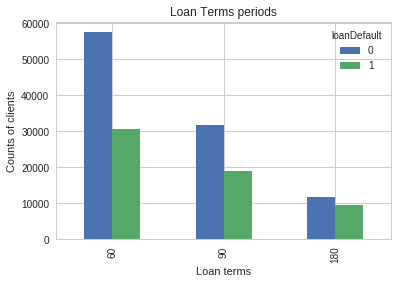

In [0]:
%matplotlib inline
pd.crosstab(data.loanTerm,data.loanDefault).plot(kind='bar')
plt.title('Loan Terms periods')
plt.xlabel('Loan terms')
plt.ylabel('Counts of clients')

Text(0, 0.5, 'Proportion of Customers')

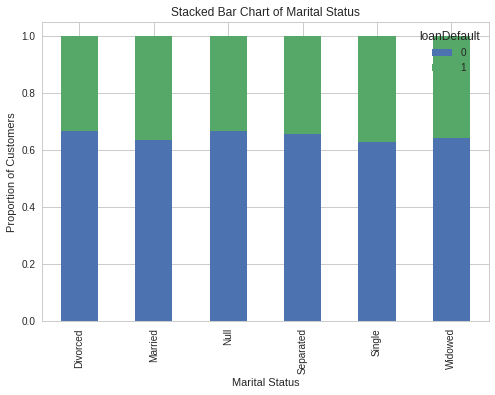

In [0]:
table=pd.crosstab(data.clientMaritalStatus,data.loanDefault)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

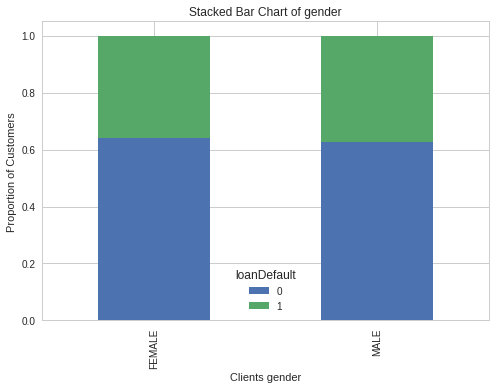

In [0]:
table=pd.crosstab(data.clientGender,data.loanDefault)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of gender')
plt.xlabel('Clients gender')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

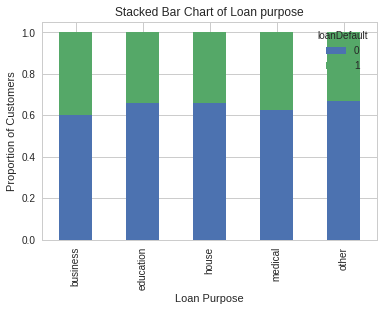

In [0]:
table=pd.crosstab(data.clientLoanPurpose,data.loanDefault)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Loan purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Proportion of Customers')

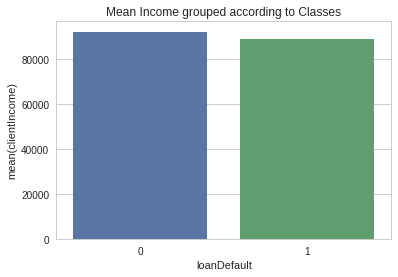

In [0]:
classes = data.groupby('loanDefault')
data_mean = classes['clientIncome'].mean().reset_index()
sns.barplot(x='loanDefault', y='clientIncome', data=data_mean)
plt.title('Mean Income grouped according to Classes');

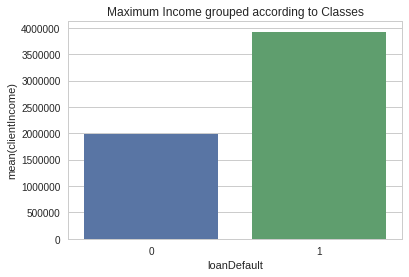

In [0]:
classes = data.groupby('loanDefault')
data_mean = classes['clientIncome'].max().reset_index()
sns.barplot(x='loanDefault', y='clientIncome', data=data_mean)
plt.title('Maximum Income grouped according to Classes');

Text(0, 0.5, 'Frequency')

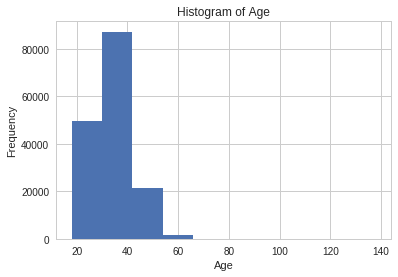

In [0]:
data.clientAge.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

most clients are in the 30-40 age range

#One hot encoding. Let's create the dummy variables

In [0]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['clientGender','clientMaritalStatus',
                       'clientResidentialStauts']

Features = encode_string(data['clientLoanPurpose'])
for col in categorical_columns:
    temp = encode_string(data[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(159596, 19)
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


** Next the numeric features must be concatenated to the numpy array by executing the code in the cell below.**

The numeric features are listed below in the list1 dataframe


In [0]:
list1= data[['clientIncome', 'clientAge','clientNumberPhoneContacts','loanNumber','clientAvgCallsPerDay','loanAmount', 'interestRate','loanTerm',
                            'max_amount_taken', 'max_tenor_taken','settleDays','firstPaymentRatio','firstPaymentDefault', 'clientTimeAtEmployer']]

lists = list1.replace('Null',0)
lists.fillna(0,inplace=True)


some columns were observed to contain "Null" as their values. A box plot is plotted for the numerical  features to get a good picture of the distribution of data. The 'Null' value will be replaced with the median value of the column. The Null values were converted to zero first, before being replaced with the median values.The mean was not used because outliers were observed in some columns and it will affect the computed values as seen in the plot below.

In [0]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values= 0, strategy='median', axis=1)
lists= imp.fit_transform(lists)

#This will look for all columns where we have 0 value and replace the 0 value with the median.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


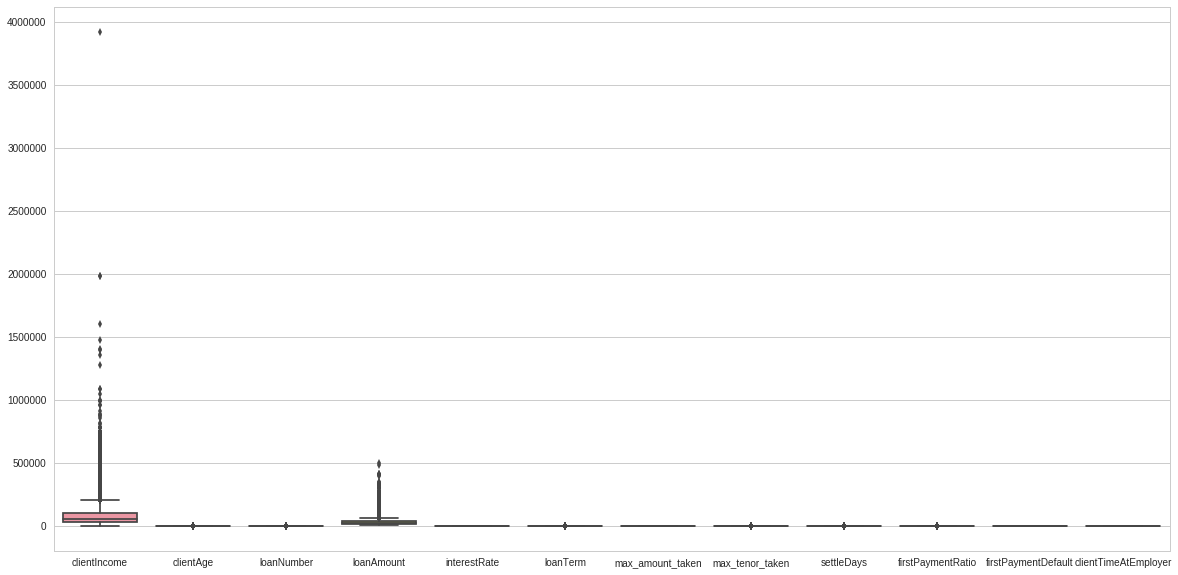

In [0]:
plt.figure(figsize=(20,10))
sns.boxplot(list1)

In [0]:
x1 = np.concatenate([Features, np.array(lists)], axis = 1)
print(x1.shape)
print(x1[:2, :])  

(159596, 33)
[[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+04
  2.80000000e+01 1.91700000e+03 4.00000000e+00 2.59357403e-01
  3.75000000e+04 1.25000000e+01 9.00000000e+01 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.25000000e+01 1.25000000e+01
  1.25000000e+01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 7.08333300e+04
  4.10000000e+01 5.67800000e+03 8.00000000e+00 2.96338843e+02
  8.45000000e+04 7.50000000e+00 1.80000000e+02 1.10500000e+02
  1.00000000e+00 1.00000000e+00 1.10500

In [0]:
y1 = np.array(data['loanDefault'])

** Let's balance the classes: Over-sampling technique  using SMOTE from the imbalance learn python library**

first, we split our data into training and test sets

In [0]:
from sklearn.model_selection import train_test_split
x1_train, x_test, y1_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)
print('Training Features Shape:', x1_train.shape)
print('Training Labels Shape:', y1_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (111717, 33)
Training Labels Shape: (111717,)
Testing Features Shape: (47879, 33)
Testing Labels Shape: (47879,)


We apply the over-sampling technique to only the training set

In [0]:
import imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
x_train, y_train = smote.fit_sample(x1_train, y1_train)
print('Training Features Balanced Shape:', x_train.shape)
print('Training Labels Balanced Shape:', y_train.shape)
print('Testing Features Balanced Shape:', x_test.shape)
print('Testing Labels Balanced Shape:', y_test.shape)


Training Features Balanced Shape: (140858, 33)
Training Labels Balanced Shape: (140858,)
Testing Features Balanced Shape: (47879, 33)
Testing Labels Balanced Shape: (47879,)


#Feature selection with PCA

I performed some feature selection with PCA but noticed that my accuracy score was lower, hence i decided to use all features. It seems most of the features are important to our target variable prediction.with principal components= 5, i got accuracy of 0.64, principal component = 11, accuracy is 0.66, while with all features, accuracy is 0.74. Below are the codes i used for the PCA .

from sklearn.decomposition import PCA

-create pca

pca = PCA(n_components=11)

-fit the data to the model

principalComponents = pca.fit_transform(x1)

-create dataframe containing principal components

x = pd.DataFrame(data = principalComponents)

**Lets scale our data :**  We use the StandardScaler function from the Scikit Learn preprocessing package to Zscore scale the numeric features. The scaler is fit only on the training data. The trained scaler is then applied to the test data. Test data should always be scaled using the parameters from the training data.

In [0]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)


#Lets implement our model : Random Forest and Confusion matrix


Most important hyperparameters of Random Forest:

1)n_estimators = n of trees

2)max_features = max number of features considered for splitting a node

3)max_depth = max number of levels in each decision tree

4)min_samples_split = min number of data points placed in a node before the node is split

5)min_samples_leaf = min number of data points allowed in a leaf node

6)bootstrap = method for sampling data points (with or without replacement)







**Based on the above explanations, I tuned my hyperparameters severally with different values before concluding to use the values in my classifier model below.**

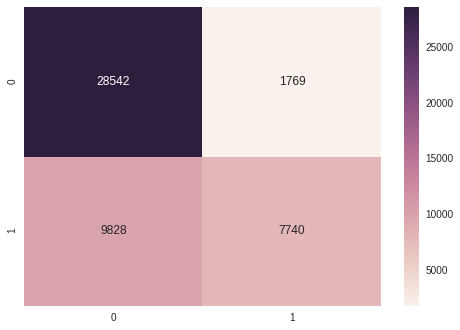

In [0]:
#Predicting the test set with random forest classifier 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

#In order to get the best of the random forest classifier, the following hyper-parameters were tuned from the default values
clf_rf = RandomForestClassifier(random_state=50, n_estimators=100, min_samples_leaf = 60,max_depth= 120, max_features = 0.9, n_jobs = -1, min_samples_split= 10)      
clr_rf = clf_rf.fit(x_train,y_train)
y_pred = clf_rf.predict(x_test)

#Ploting the confusion matrix
cm2 = confusion_matrix(y_test,y_pred)
sns.heatmap(cm2,annot=True,fmt="d")

In [0]:
from sklearn.model_selection import cross_val_score
clf_rf_score = cross_val_score(clf_rf, x1, y1, cv=10, scoring='roc_auc')
print("=== All AUC Scores ===")
print(clf_rf_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", round(clf_rf_score.mean(),2))

=== All AUC Scores ===
[0.75220231 0.78642918 0.79717822 0.75228884 0.78271196 0.79497718
 0.79166238 0.77523554 0.77996955 0.73781747]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7750472617412962


**Let's Plot the ROC curve**

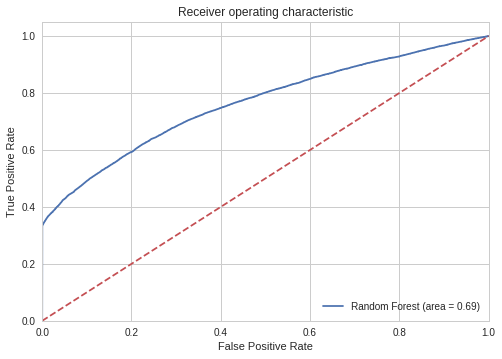

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RF_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, clf_rf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % RF_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

**Performance Metrics: Evaluating the Random Forest Network model on Test set **

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
ac = accuracy_score(y_test,y_pred)
print('Accuracy of random forest classifier on test set: ', round(ac,2))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83     30311
           1       0.81      0.44      0.57     17568

   micro avg       0.76      0.76      0.76     47879
   macro avg       0.78      0.69      0.70     47879
weighted avg       0.77      0.76      0.74     47879

Accuracy of random forest classifier on test set:  0.76


 **Performance Metrics: Evaluating the Random Forest model on Training set **

In [0]:
from sklearn.metrics import classification_report

y_pred2 = clf_rf.predict(x_train)
print(classification_report(y_train, y_pred2))
ac = accuracy_score(y_train,y_pred2)
print('Accuracy of random forest classifier on train set: ',round(ac,2))

              precision    recall  f1-score   support

           0       0.74      0.95      0.84     70429
           1       0.94      0.67      0.78     70429

   micro avg       0.81      0.81      0.81    140858
   macro avg       0.84      0.81      0.81    140858
weighted avg       0.84      0.81      0.81    140858

Accuracy of random forest classifier on train set:  0.81


**Interpretation**


1. The confusion matrix shows the following characteristics based on the test set;

    a) most of the positive cases (loan payment defaulters) are not correctly classified, 7740 vs. 9828. 

    b) most negative cases (non payment defaulters)are scored correctly, 28542 vs 1769.   

2. The overall accuracy is 0.77.  Accuracy figures should always be regarded with healthy skepticism.

3. The class imbalance is confirmed. of the 47879 test cases, 30311 are non loan defaulters while 17568 are loan payment defaulters. This shows most of the clients are non loan payment defaulters.

4. The precision, recall and F1 all show that negative cases(non defaulters) are classified reasonably well than the positive cases (loan payment defaulters). It is these positive cases that are of greatest importance to 'Carbon' organization , hence more efforts could be done in the nearest future to improve the performance of the model in correctly predicting the loan payment defaulters. 

#More tuning of the hyperparameters of the random forest model with the Grid and Random regressors



**Tuning hyperparameters with grid search**

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)

param_grid = [
{'n_estimators': [50,100],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [80,90,110],
 'bootstrap': [False],
 'min_samples_leaf': [10,20,50],
 'min_samples_split': [30]}
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=3,verbose=2,return_train_score=True)
grid_search_forest= grid_search_forest.fit(x_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=50, total=  44.8s
[CV] bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.3s remaining:    0.0s


[CV]  bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=50, total=  45.2s
[CV] bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=50 
[CV]  bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=50, total=  49.0s
[CV] bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100 
[CV]  bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100, total= 1.4min
[CV] bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100 
[CV]  bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100, total= 1.5min
[CV] bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100 
[CV]  bootstrap

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 70.4min finished


In [0]:
grid_search_forest.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 30,
 'n_estimators': 50}

In [0]:
#find the best model of grid search
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=80,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

**Performance Metrics: Evaluating the Random Forest Grid CV model on Test set**

In [0]:
# Performance metrics
grid_best2= grid_search_forest.best_estimator_.predict(x_test)
errors = abs(grid_best2 - y_test)
# Calculate mean absolute percentage error (MAPE)
mape= 100*(np.mean(errors)/y_test)
accuracy = (100 - mape)
print('The best model from grid-search has an accuracy of', accuracy,'%'  'on the test data')



The best model from grid-search has an accuracy of [65.73869175 65.73869175 65.73869175 ...        -inf        -inf
 65.73869175] %on the test data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


**Performance Metrics: Evaluating the Random Forest Grid CV model on Training set**

In [0]:
# Performance metrics
grid_best= grid_search_forest.best_estimator_.predict(x_train)
errors = abs(grid_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape= 100*(np.mean(errors)/y_train)
accuracy = (100 - mape)
print('The best model from grid-search has an accuracy of', accuracy,'%'  'on the training data')




The best model from grid-search has an accuracy of [       -inf        -inf        -inf ... 76.05004496 76.05004496
 76.05004496] %on the training data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


**Tuning hyperparameters with randomized search**

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop =100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 120, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20, 30, 45]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 7, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [50, 57, 64, 71, 78, 85, 92, 99, 106, 113, 120, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [5, 7, 10],
 'min_samples_split': [20, 30, 45],
 'n_estimators': [20, 40, 60, 80, 100]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter =20,scoring='neg_mean_absolute_error', 
                              cv = 10, verbose=2, random_state=42, n_jobs=1,
                              return_train_score=True)

# Fit the random search model
rf_random = rf_random.fit(x_train, y_train);

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True, total=   4.0s
[CV] n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True, total=   4.2s
[CV] n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True, total=   4.1s
[CV] n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True, total=   4.1s
[CV] n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True, total=   4.1s
[CV] n_estimators=20, min_samples_split=30, min_samples_leaf=5, max_features=sqrt, max_depth=113, bootstrap=True 
[CV]  n_estimators=20, min_s

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 174.1min finished


**Performance Metrics: Evaluating the RandomForest Regressor model on Test set**

In [0]:
# Performance metrics (MAPE)
random_best= rf_random.best_estimator_.predict(x_test)
errors = abs(random_best - y_test)
# Calculate mean absolute percentage error (MAPE)
mape= 100*(np.mean(errors)/y_test)
accuracy = (100 - mape)
print('The best model from grid-search has an accuracy of', accuracy,'%'  'on the training data')
  

The best model from grid-search has an accuracy of [66.80577582 66.80577582 66.80577582 ...        -inf        -inf
 66.80577582] %on the training data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


** Performance Metrics: Evaluating the RandomForest Regressor model on Training set**

In [0]:
# Performance metrics (MAPE)
random_best= rf_random.best_estimator_.predict(x_train)
errors = abs(random_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape= 100*(np.mean(errors)/y_train)
accuracy = (100 - mape)
print('The best model from grid-search has an accuracy of', accuracy,'%'  'on the training data')
  


The best model from grid-search has an accuracy of [      -inf       -inf       -inf ... 82.5813274 82.5813274 82.5813274] %on the training data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


**Remarks on my random forest, GridCV  and Randomized search models**

1) I tried creating a classification report, but got error thaat  classification report cannot handle binary data(from the labels) and continous data from the randomforest regressor.

2) I also got an error when calculating accuracy that true divide by zero was observed . I donot know why. i sort for help and searched the internet but could not fix it. that's why i have arrays of the same accuracy value instead of a single mean value.

3) The accuracy for the random forest classifier on the test data is higher than those of the grid cv regressor and randomized search regressor models. Hence, I will go with the random forest classifier.

4) I plotted the ROC curve and noticed my curve i smooth, I searched for help in know why , but couln't get any. The important thing is that the curve is cloe th the upper left part of the plot.